# EMG data analysis

In [175]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import neurokit2 as nk

import warnings
warnings.filterwarnings("ignore")

In [3]:
with open('../datasets/emg_recording.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
data[0].keys()

dict_keys(['states', 'user_signals', 'actions', 'optimal_actions', 'rewards', 'goal', 'episode_durations', 'model_name'])

In [5]:
emg = np.vstack([data[i]["user_signals"] for i in range(len(data))])
actions = np.vstack([data[i]["actions"] for i in range(len(data))]).squeeze(-2)
optimal_actions = np.vstack([data[i]["optimal_actions"] for i in range(len(data))])

print(emg.shape, actions.shape, optimal_actions.shape)

(2849, 8, 200)


In [10]:
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,
)
embeddings = reducer.fit_transform(emg.reshape(len(emg), -1))

/Users/ran.w/miniconda3/envs/emg_control/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


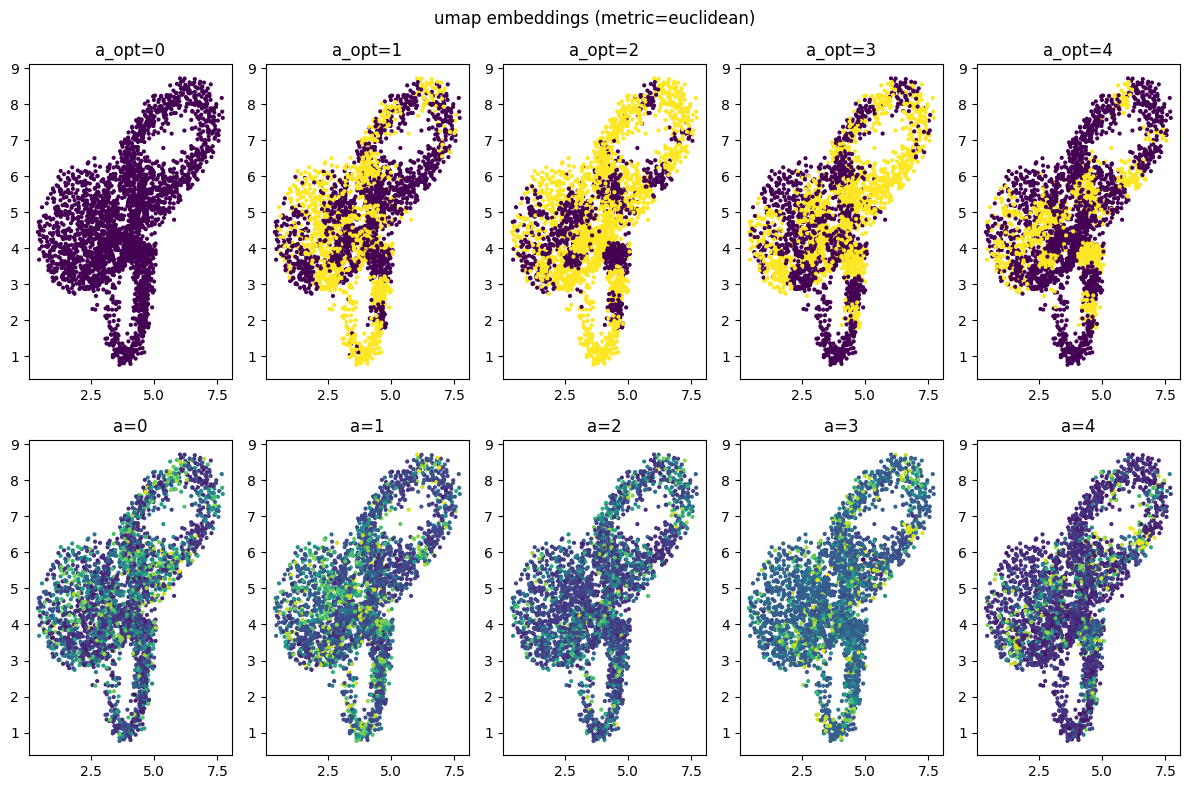

In [37]:
# plot embedding by actions
num_cols = optimal_actions.shape[-1]
fig, ax = plt.subplots(2, num_cols, figsize=(12, 8))
for i in range(num_cols):
    ax[0, i].scatter(embeddings[:, 0], embeddings[:, 1], c=optimal_actions[:, i], s=4)
    ax[0, i].set_title(f"a_opt={i}")

    ax[1, i].scatter(embeddings[:, 0], embeddings[:, 1], c=actions[:, i], s=4)
    ax[1, i].set_title(f"a={i}")
fig.suptitle("umap embeddings (metric=euclidean)", y=0.98)
plt.tight_layout()
plt.show()

## Reconstruct raw EMG sequence

In [132]:
def reconstruct_raw_seq(signals, overlap=180):
    """Remove overlapping window and concat non-duplicate sequences"""
    append_len = signals.shape[-1] - overlap
    rec_signals = np.concatenate([
        signals[i, :, -append_len:] for i in range(1, len(signals))
    ], axis=-1)
    rec_signals = np.concatenate([signals[0], rec_signals], axis=-1)
    return rec_signals

num_timesteps = data[0]["user_signals"].shape[0]
window_size = data[0]["user_signals"].shape[-1]
emg_rec = reconstruct_raw_seq(
    data[0]["user_signals"], overlap=180
)
act_rec = reconstruct_raw_seq(
    data[0]["actions"].reshape(num_timesteps, -1, 1).tile((1, 1, window_size)), 
    overlap=180
)
opt_act_rec = reconstruct_raw_seq(
    data[0]["optimal_actions"].reshape(num_timesteps, -1, 1).tile((1, 1, window_size)), 
    overlap=180
)

print(emg_rec.shape, act_rec.shape, opt_act_rec.shape)

(8, 2780) (5, 2780) (5, 2780)


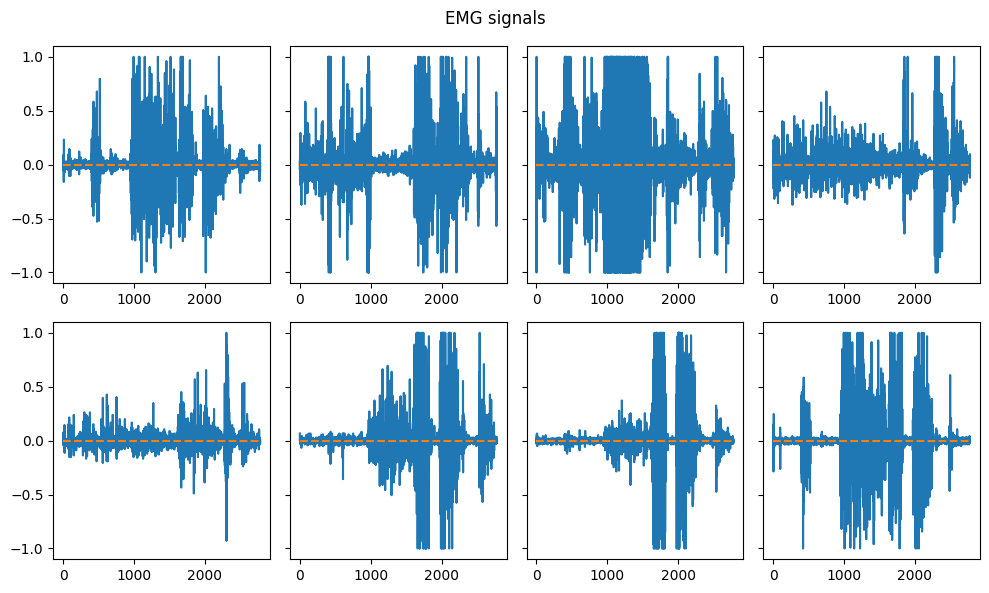

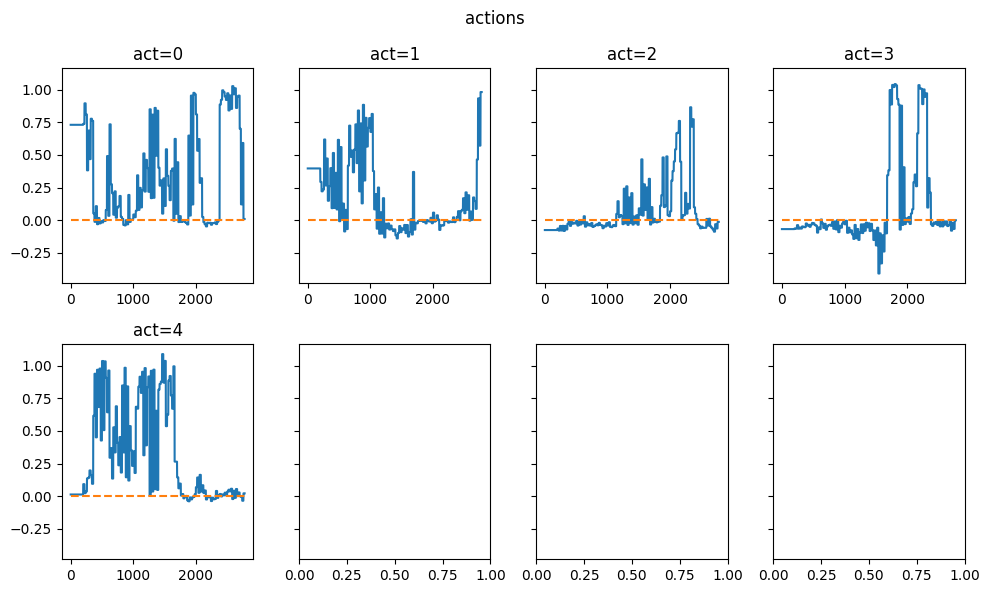

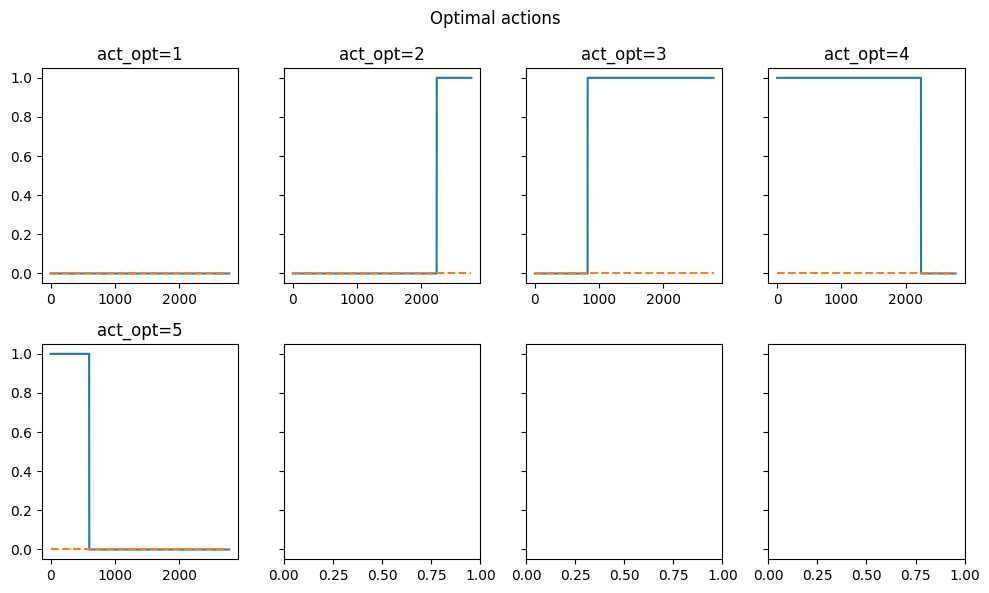

In [133]:
# plot emg signals
fig, ax = plt.subplots(2, 4, figsize=(10, 6), sharey=True)
ax = ax.flat
for i in range(len(emg_rec)):
    ax[i].plot(emg_rec[i])
    ax[i].plot([0, len(emg_rec[i])], [0, 0], "--")
fig.suptitle("EMG signals", y=0.98)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 4, figsize=(10, 6), sharey=True)
ax = ax.flat
for i in range(len(act_rec)):
    ax[i].plot(act_rec[i])
    ax[i].plot([0, len(act_rec[i])], [0, 0], "--")
    ax[i].set_title(f"act={i}")
fig.suptitle("actions", y=0.98)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 4, figsize=(10, 6), sharey=True)
ax = ax.flat
for i in range(len(opt_act_rec)):
    ax[i].plot(opt_act_rec[i])
    ax[i].plot([0, len(opt_act_rec[i])], [0, 0], "--")
    ax[i].set_title(f"act_opt={i+1}")
fig.suptitle("Optimal actions", y=0.98)
plt.tight_layout()
plt.show()


## Try neurokit emg analyze

In [134]:
# emg_sim = nk.emg_simulate(duration=20, sampling_rate=1000, burst_number=3)
emg_processed, info = nk.emg_process(emg_rec[0], sampling_rate=1000)

In [135]:
emg_processed

,EMG_Raw,EMG_Clean,EMG_Amplitude,EMG_Activity,EMG_Onsets,EMG_Offsets
0,-0.019608,0.000070,-0.010178,0.0,0,0
1,0.011765,0.019641,-0.009459,0.0,0,0
2,-0.019608,-0.020742,-0.008754,0.0,0,0
3,0.090196,0.084340,-0.008064,0.0,0,0
4,0.003922,-0.002979,-0.007391,0.0,0,0
...,...,...,...,...,...,...
2775,0.027451,0.047911,0.002222,0.0,0,0
2776,0.058824,0.077976,0.002228,0.0,0,0
2777,-0.074510,-0.061886,0.002233,0.0,0,0
2778,-0.050980,-0.049121,0.002236,0.0,0,0


In [136]:
emg_processed.sum()

EMG_Raw         -1.307451e+01
EMG_Clean       -2.393918e-15
EMG_Amplitude    1.094300e+02
EMG_Activity     1.506000e+03
EMG_Onsets       3.000000e+00
EMG_Offsets      3.000000e+00
dtype: float64

In [137]:
emg_processed.groupby("EMG_Activity").std()

,EMG_Raw,EMG_Clean,EMG_Amplitude,EMG_Onsets,EMG_Offsets
EMG_Activity,,,,,
0.0,0.035243,0.033460,0.001598,0.000000,0.048488
1.0,0.272791,0.246738,0.040715,0.044603,0.000000


In [138]:
def moving_mean(signal, window_size=10):
    return np.array([np.mean(signal[i:i+window_size]) for i in range(len(signal) - window_size)])

def moving_std(signal, window_size=10):
    return np.array([np.std(signal[i:i+window_size]) for i in range(len(signal) - window_size)])

channel = 0
window_size = 30
emg_rec_moving_mean = moving_mean(emg_rec[channel], window_size=window_size)
emg_rec_moving_std = moving_std(emg_rec[channel], window_size=window_size)

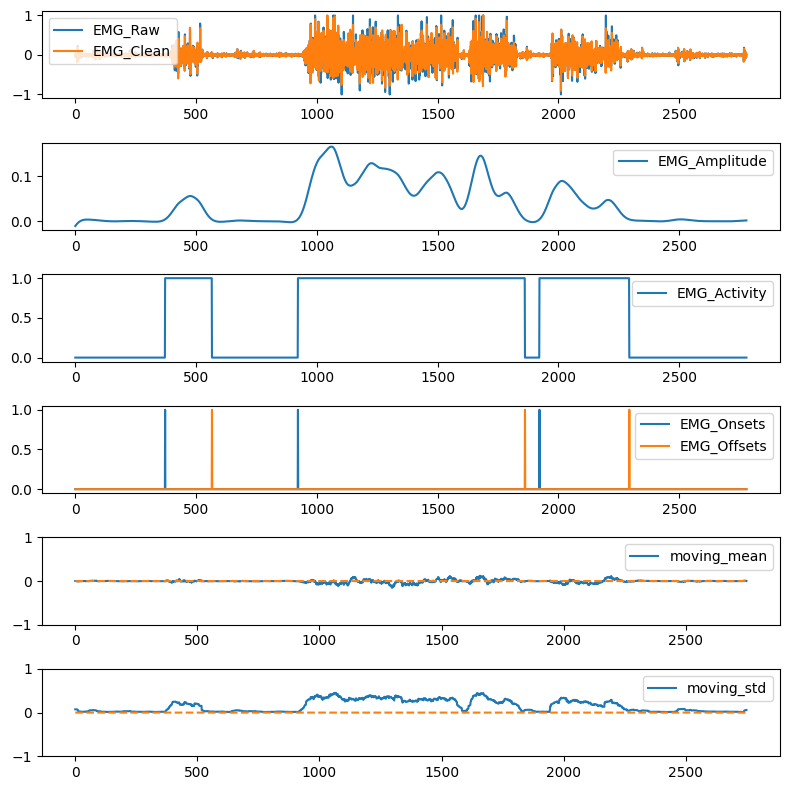

In [139]:
fig, ax = plt.subplots(6, 1, figsize=(8, 8))
ax[0].plot(emg_processed["EMG_Raw"], label="EMG_Raw")
ax[0].plot(emg_processed["EMG_Clean"], label="EMG_Clean")
ax[0].legend()

ax[1].plot(emg_processed["EMG_Amplitude"], label="EMG_Amplitude")
ax[1].legend()

ax[2].plot(emg_processed["EMG_Activity"], label="EMG_Activity")
ax[2].legend()

ax[3].plot(emg_processed["EMG_Onsets"], label="EMG_Onsets")
ax[3].plot(emg_processed["EMG_Offsets"], label="EMG_Offsets")
ax[3].legend()

ax[4].plot(emg_rec_moving_mean, label="moving_mean")
ax[4].plot(np.zeros_like(emg_rec_moving_mean), "--")
ax[4].set_ylim([-1, 1])
ax[4].legend()

ax[5].plot(emg_rec_moving_std, label="moving_std")
ax[5].plot(np.zeros_like(emg_rec_moving_std), "--")
ax[5].set_ylim([-1, 1])
ax[5].legend()

plt.tight_layout()
plt.show()

## Compute window features

In [149]:
def compute_emg_activity(emg_signals):
    """Compute for each channel whether activity is 1"""
    num_channels = emg_signals.shape[0]
    emg_activity = np.stack(
        [nk.emg_process(emg_rec[i], sampling_rate=1000)[0]["EMG_Activity"] for i in range(num_channels)]
    )
    return emg_activity

def make_overlap_windows(signal, window_size=200, overlap=180):
    """Convert reconstructed signals back to windows. Currently use this for activity signals.
    out_size=[num_steps, window_size]
    """
    append_len = window_size - overlap
    sig_windows = [signal[:window_size]]
    num_windows = (len(signal) - window_size) // append_len
    for i in range(num_windows):
        start = (i + 1) * append_len
        sig_windows.append(signal[start:start+window_size])
    sig_windows = np.stack(sig_windows)
    return sig_windows

def compute_emg_features(emg_signals, emg_activity):
    nan_mask = np.ones_like(emg_activity)
    nan_mask[emg_activity == 0] = np.nan
    std = np.nanstd(nan_mask * emg_signals, axis=-1)
    std = np.nan_to_num(std, nan=0)
    return std

emg_activity = compute_emg_activity(emg_rec)
emg_activity_window = np.stack([make_overlap_windows(emg_activity[i]) for i in range(len(emg_activity))], axis=1)
std_features = compute_emg_features(data[0]["user_signals"].numpy(), emg_activity_window)

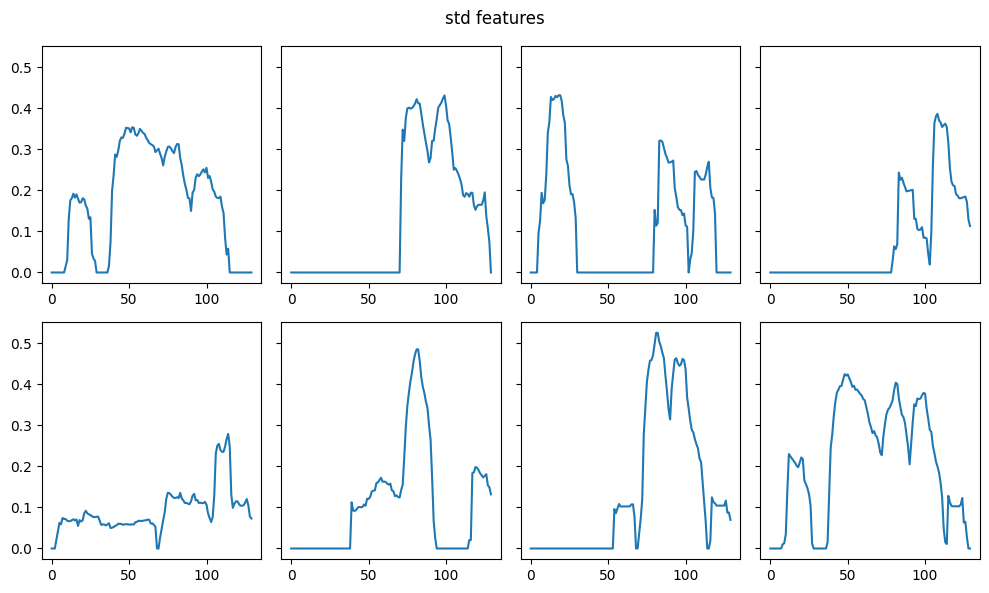

In [171]:
fig, ax = plt.subplots(2, 4, figsize=(10, 6), sharey=True)
ax = ax.flat
for i in range(len(ax)):
    ax[i].plot(std_features[:, i])

plt.suptitle("std features", y=0.98)
plt.tight_layout()
plt.show()

In [176]:
# compute features for all episodes
std_features = [None] * len(data)
for i in range(len(data)):
    emg_rec = reconstruct_raw_seq(data[i]["user_signals"], overlap=180)
    emg_activity = compute_emg_activity(emg_rec)
    emg_activity_window = np.stack([make_overlap_windows(emg_activity[i]) for i in range(len(emg_activity))], axis=1)
    std_features[i] = compute_emg_features(data[i]["user_signals"].numpy(), emg_activity_window)
std_features = np.vstack(std_features)

actions = np.vstack([data[i]["actions"] for i in range(len(data))]).squeeze(-2)
optimal_actions = np.vstack([data[i]["optimal_actions"] for i in range(len(data))])

print(std_features.shape, actions.shape, optimal_actions.shape)

(2849, 8) (2849, 5) (2849, 5)


In [177]:
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,
)
embeddings = reducer.fit_transform(std_features)

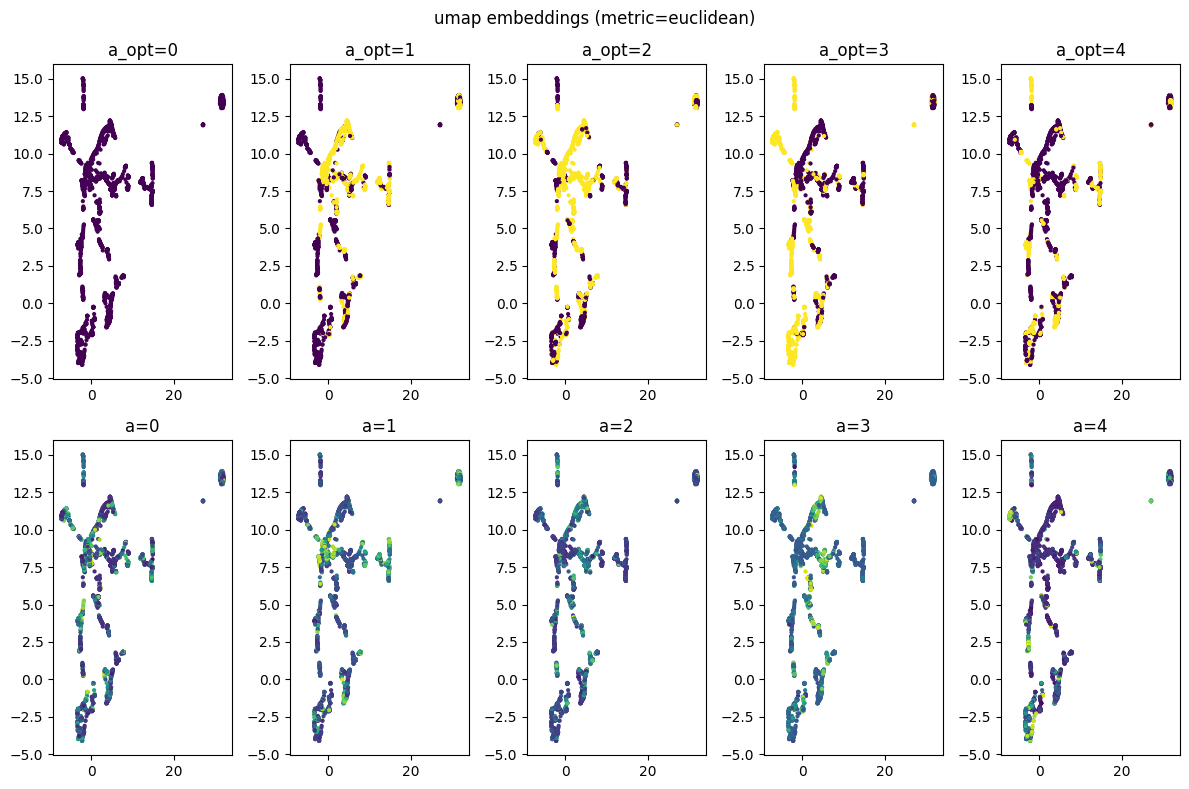

In [178]:
# plot embedding by actions
num_cols = optimal_actions.shape[-1]
fig, ax = plt.subplots(2, num_cols, figsize=(12, 8))
for i in range(num_cols):
    ax[0, i].scatter(embeddings[:, 0], embeddings[:, 1], c=optimal_actions[:, i], s=4)
    ax[0, i].set_title(f"a_opt={i}")

    ax[1, i].scatter(embeddings[:, 0], embeddings[:, 1], c=actions[:, i], s=4)
    ax[1, i].set_title(f"a={i}")
fig.suptitle("umap embeddings (metric=euclidean)", y=0.98)
plt.tight_layout()
plt.show()